# Loading Data

In [1]:
import pandas as pd

In [2]:
tweet = pd.read_csv('C:/WinPython_64bit/notebooks/Kapita Selekta/Scrapping Tweet/TweetClean.csv')
tweet.head()

,Unnamed: 0,Tweet,TweetClean_NonPT,TweetClean_PT
0,0,Udah ngeh blm min?\r\nItu sms 86mb jam 16.06 t...,sadar min sms 86 mb jam 16.06 tanggal 30.01 ke...,sadar min sms mb jam tanggal kemarin paketin t...
1,1,Dibaca itu yang kemarin min 86 mb... Pas jam 1...,dibaca kemarin min 86 mb .. jam 16.06 paketin ...,dibaca kemarin min mb jam paketin
2,2,@IndosatCare pusing saya min pake indosat... \...,pusing min pakai .. kuota kesedot,pusing min kuota
3,3,"Sudah min sudah, lagian apa yang mau di clear ...",min clear cache .. dibilang diuninstal diinsta...,min dibilang diuninstal diinstal sebulan min k...
4,4,"@IndosatCare masi juga lelet euy,, apakah bts ...",masi lelet euy bts bermasalah didaerah karna k...,masi didaerah karna kantor


In [3]:
listTweet=tweet['TweetClean_PT'].values.astype('U')
listTweet = [d for d in listTweet]

# MODEL VSM TF

In [4]:
#Pembentukan model svm TF untuk LDA
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer()

X = tf_vectorizer.fit_transform(listTweet)
X_terms = tf_vectorizer.get_feature_names()
# Mengapa tf bukan tfidf?
# Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
# Saran: untuk penelitian VS di Industri.
X.shape

(4359, 3747)

In [5]:
import numpy as np
#menghapus tf yang bernilai 0
nidx = np.array(range(len(listTweet)))
nidx = nidx[X.getnnz(1)>0] # Remove Zero Rows
data_bersih = [listTweet[i] for i in nidx]
X = X[X.getnnz(1)>0] # Remove Zero Rows
X_terms = tf_vectorizer.get_feature_names()
print(X.shape)

(4359, 3747)


# Percobaan berbagai Model

## K-Means ++

In [6]:
from sklearn import cluster
from tqdm import tqdm

seed = 99 #harus ditetapkan untuk mengoptimalkan cost function 
#atau untuk konvergen lebih cepat aja dalam pengelompokannya, 
#tidak ada hubungan antara nilai pasti dari seed dan hasil pengelompokan KMeans
#seed ini harus ditentukan terlebih dahulu agar tidak menghasilkan pengelompokan yg berbeda setiap dijalankan aja
C=[]
K=[] 
kelompok = []
for k in tqdm(range(2,9)):
    kelompok.append(k)
    kmPP = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, n_jobs=-1, random_state = seed)
    K.append(kmPP.fit(X))
    C.append(kmPP.predict(X))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 22.72s/it]


In [7]:
#Evaluasi : Internal . Contoh Silouette Coefficient ==> warning hanya cocok untuk k-means/menggunakan centroid
from sklearn.metrics import silhouette_score as siluet

ScoreSiluet=[]
i=int(kelompok[0])
for res in C:
    ScoreSiluet.append(siluet(X,res))
    print("K={} ,nilai siluet {} ".format(i, siluet(X,res)))
    i=i+1
print("dengan score terbesar {}".format(max(ScoreSiluet)))    

K=2 ,nilai siluet 0.09437994744243708 
K=3 ,nilai siluet 0.04885243809696042 
K=4 ,nilai siluet 0.043854332683526155 
K=5 ,nilai siluet 0.04755323697187677 
K=6 ,nilai siluet 0.03905870017001625 
K=7 ,nilai siluet 0.035785138856716046 
K=8 ,nilai siluet 0.03689263101676078 
dengan score terbesar 0.09437994744243708


In [ ]:
#dengan 9 Kluster yang menurut Evaluasi secara internal terbaik 
import seaborn as sns
import matplotlib.pyplot as plt

for i in C:
    sns.countplot(i)
    plt.show()

## Mini Batch K-Means++

In [9]:
from sklearn import cluster
from tqdm import tqdm

# MiniBatch k-Means 
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
# minibatch "tidak bisa parallel"!!!...
# parameter penting km = batch_size ... pada aplikasi sesungguhnya disarankan "minimal" 3xk

seed = 99 #harus ditetapkan untuk mengoptimalkan cost function 
#atau untuk konvergen lebih cepat aja dalam pengelompokannya, 
#tidak ada hubungan antara nilai pasti dari seed dan hasil pengelompokan KMeans
#seed ini harus ditentukan terlebih dahulu agar tidak menghasilkan pengelompokan yg berbeda setiap dijalankan aja
Cmb=[]
Kmb=[] 
kelompokMb = []
for k in tqdm(range(2,9)):
    kelompokMb.append(k)
    MiniBatchKM = cluster.MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300,batch_size=10 , tol=0.0001, random_state = seed) 
    Kmb.append(MiniBatchKM.fit(X))
    Cmb.append(MiniBatchKM.predict(X))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.75it/s]


In [10]:
#Evaluasi : Internal . Contoh Silouette Coefficient ==> warning hanya cocok untuk k-means/menggunakan centroid
from sklearn.metrics import silhouette_score as siluet

ScoreSiluet=[]
i=int(kelompok[0])
for res in Cmb:
    ScoreSiluet.append(siluet(X,res))
    print("K={} ,nilai siluet {} ".format(i, siluet(X,res)))
    i=i+1
print("dengan score terbesar {}".format(max(ScoreSiluet)))   

K=2 ,nilai siluet 0.11145188520797432 
K=3 ,nilai siluet 0.09586138181378055 
K=4 ,nilai siluet 0.05065799006707683 
K=5 ,nilai siluet 0.08491937965692936 
K=6 ,nilai siluet -0.08900710298680253 
K=7 ,nilai siluet 0.035560909848090724 
K=8 ,nilai siluet 0.1019624038081332 
dengan score terbesar 0.11145188520797432


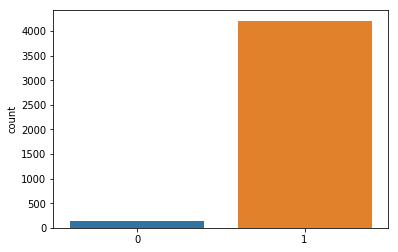

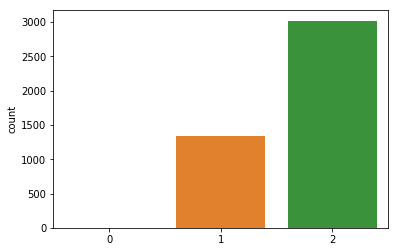

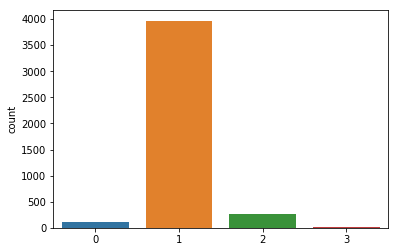

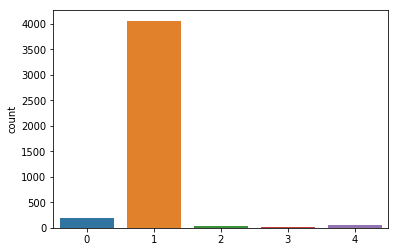

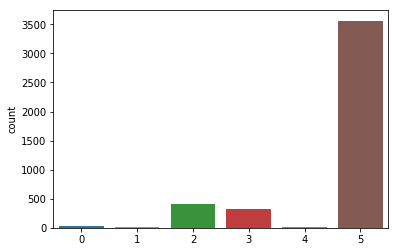

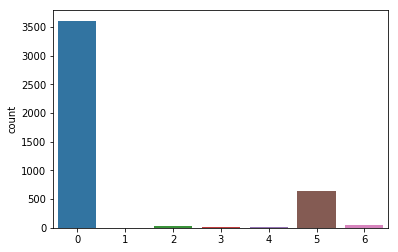

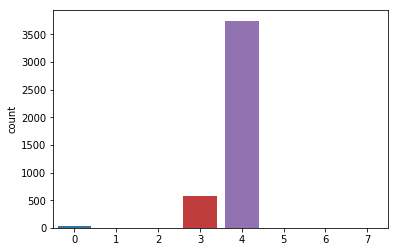

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in Cmb:
    sns.countplot(i)
    plt.show()

## DBSCAN Clustering

In [12]:
from sklearn import cluster

DBScan = cluster.DBSCAN(eps=1)
DBScan.fit(X)
C_DB = DBScan.labels_.astype(np.int)

In [13]:
siluet(X,C_DB)

-0.19002004734996486

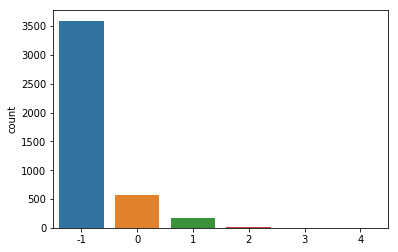

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(C_DB)
plt.show()

## LDA Clustering

In [15]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda=[]
for n_topics in tqdm(range(2,9)):
    model=LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(X)
    lda.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:50<00:00, 32.95s/it]


In [16]:
vsm_topics=[]
for i in tqdm(lda):
    vsm_topics.append(i.transform(X))
    #ini matriks topik terhadap masing-masing kata 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.70s/it]


In [17]:
doc_topic=[]
for i in tqdm(range(len(vsm_topics))):
    doc_topic.append([a.argmax()+1 for a in vsm_topics[i]]) # topic of docs

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 60.82it/s]


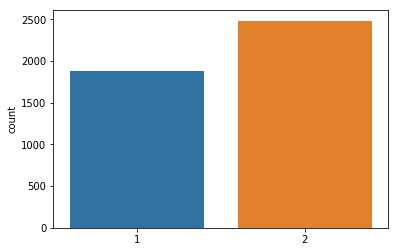

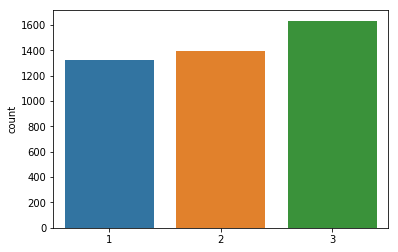

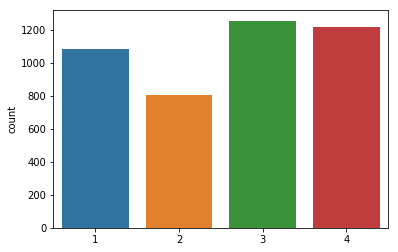

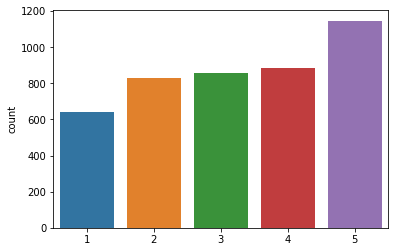

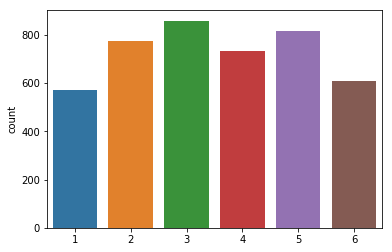

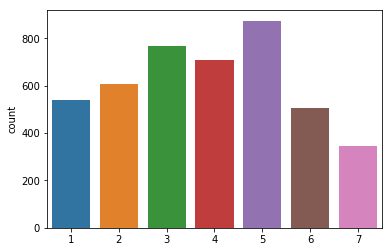

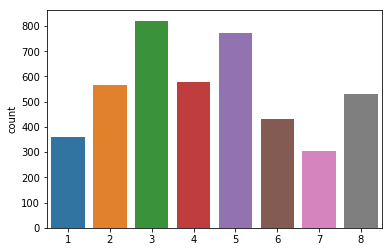

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in doc_topic:
    sns.countplot(i)
    plt.show() 

In [19]:
def print_Topics(model, feature_names, Top_Topics, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:Top_Topics]):
        print("Topic #%d:" %(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [34]:
# Mari kita coba maknai masing-masing topic ini
Top_Words=15 #ini mau memunculkan berapa banyak kata, untuk memudahkan pendefinisian kelompok
Ntopic=2
print('Printing top {0} Topics, with top {1} Words:'.format(Ntopic, Top_Words))
print_Topics(lda[Ntopic-2], X_terms,Ntopic, Top_Words)

Printing top 2 Topics, with top 15 Words:
Topic #1:
min sinyal ya dm nomor pulsa kali banget nan jaring nya dokter kartu internet layan
Topic #2:
pulsa paket kuota ya sms min internet data langgan cek kah jam daftar rb isi


In [32]:
Ntopic=6
Vectorized = tf_vectorizer
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda[Ntopic-2], X, Vectorized)  

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      20.768083        1       1  0.112335 -0.052745
1      19.778371        1       2  0.158884  0.016841
3      17.021515        1       3 -0.044234  0.087136
4      16.825936        1       4  0.047785  0.019429
0      13.298093        1       5 -0.149799  0.106945
5      12.308001        1       6 -0.124971 -0.177605, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
2559  Default   588.000000          paket   588.000000  30.0000  30.0000
886   Default   306.000000             dm   306.000000  29.0000  29.0000
3195  Default   349.000000         sinyal   349.000000  28.0000  28.0000
2833  Default  1609.000000          pulsa  1609.000000  27.0000  27.0000
1846  Default   524.000000          kuota   524.000000  26.0000  26.0000
3244  Default   362.000000            sms   362.000000  25.0000  25.0000
2253  Default   148.000000            nan   148.000000  24.0000  24.0000
2903  Default   139.000000     registrasi   139.000000  23.0000  23.0000
1882  Default   313.000000        langgan   313.000000  22.0000  22.0000
3712  Default   701.000000             ya   701.000000  21.0000  21.0000
1517  Default   179.000000            kak   179.000000  20.0000  20.0000
1077  Default   135.000000             gb   135.000000  19.0000  19.0000
1374  Default   218.000000            isi   218.000000  18.0000  18.0000
2411  Default   216.000000          nomor   216.000000  17.0000  17.0000
232   Default   214.000000         banget   214.000000  16.0000  16.0000
1013  Default    86.000000        freedom    86.000000  15.0000  15.0000
615   Default   297.000000           data   297.000000  14.0000  14.0000
2151  Default   774.000000            min   774.000000  13.0000  13.0000
1357  Default   412.000000       internet   412.000000  12.0000  12.0000
2548  Default   140.000000           pagi   140.000000  11.0000  11.0000
2889  Default   211.000000             rb   211.000000  10.0000  10.0000
1429  Default   189.000000         jaring   189.000000   9.0000   9.0000
897   Default   106.000000         dokter   106.000000   8.0000   8.0000
1066  Default    70.000000           gara    70.000000   7.0000   7.0000
1896  Default   170.000000          layan   170.000000   6.0000   6.0000
1288  Default    94.000000          ilang    94.000000   5.0000   5.0000
3203  Default   143.000000           sisa   143.000000   4.0000   4.0000
1529  Default   275.000000           kali   275.000000   3.0000   3.0000
3085  Default    71.000000        selamat    71.000000   2.0000   2.0000
2154  Default    50.000000         minggu    50.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
83     Topic6     5.428587  alhamdulillah     7.063639   1.8316  -6.4407
1296   Topic6    10.699951             in    14.987323   1.7580  -5.7622
1882   Topic6   172.523329        langgan   313.519687   1.4976  -2.9819
1684   Topic6    13.144814          kerja    19.365327   1.7075  -5.5564
2930   Topic6    56.016281         respon   107.360564   1.4444  -4.1068
2520   Topic6    19.551602          orang    31.511874   1.6176  -5.1594
3164   Topic6    11.587527             si    17.735022   1.6693  -5.6825
3427   Topic6    17.417210       tenggang    32.469512   1.4721  -5.2750
706    Topic6    10.939868       dibilang    18.315177   1.5796  -5.7400
2151   Topic6   179.742838            min   774.804256   0.6338  -2.9409
1054   Topic6    37.167281          ganti    95.028272   1.1562  -4.5170
2048   Topic6    24.262478        manusia    54.328522   1.2888  -4.9435
1513   Topic6    81.872463            kah   302.597691   0.7877  -3.7273
1643   Topic6    51.518521        kemarin   175.720112   0.8680  -4.1905
1607   Topic6    28.546144         kecewa    81.971044   1.0401  -4.7809
3206   Topic6    16.8

## NMF Clustering

In [22]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

nmf=[]
for n_topics in tqdm(range(2,9)):
    model=NMF(n_components=n_topics, random_state=0).fit(X)
    nmf.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.10it/s]


In [23]:
vsm_topics=[]
for i in tqdm(nmf):
    vsm_topics.append(i.transform(X))
    #ini matriks topik terhadap masing-masing kata 

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 142.63it/s]


In [24]:
doc_topic=[]
for i in tqdm(range(len(vsm_topics))):
    doc_topic.append([a.argmax()+1 for a in vsm_topics[i]]) # topic of docs

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 73.80it/s]


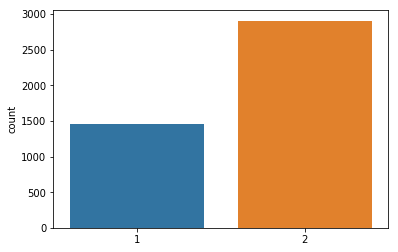

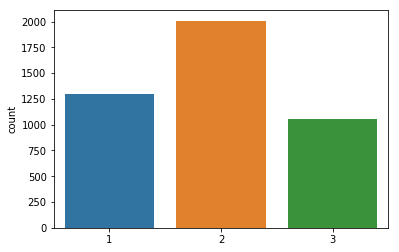

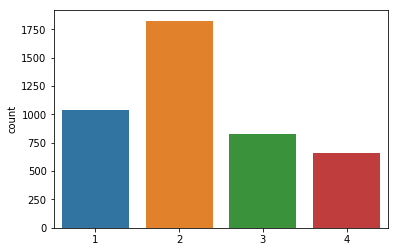

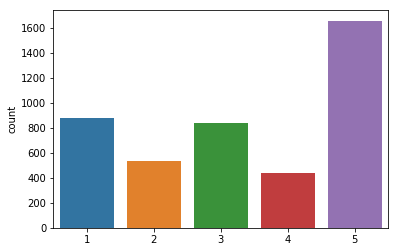

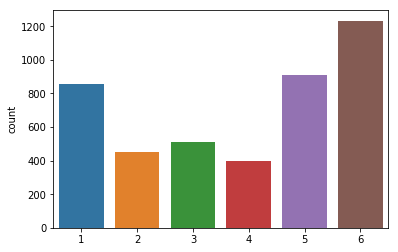

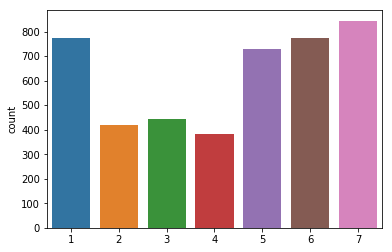

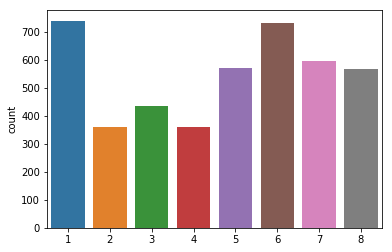

In [25]:
# mari kita plot
import matplotlib.pyplot as plt
import seaborn as sns
for i in doc_topic:
    sns.countplot(i)
    plt.show() 